In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt

In [2]:
tf.random.set_seed(23)

In [3]:
tf.keras.backend.clear_session()

In [4]:
# Cargar y Preprocesar el Dataset
dataset_dir = "../datasets_plantas"
image_size = (460, 440)  # MobileNetV3 espera imágenes de 440x440
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=True,
    follow_links=False,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "val"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=False,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    labels="inferred",
    label_mode="int",
    image_size=image_size,
    interpolation="bicubic",
    batch_size=batch_size,
    shuffle=False,
)

# Obtener los nombres de las clases (ordenados por el directorio)
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Clases detectadas: {class_names}")
print(f"Número de clases: {num_classes}")


Found 692 files belonging to 8 classes.
Found 82 files belonging to 8 classes.
Found 95 files belonging to 8 classes.
Clases detectadas: ['apamate', 'araguaney', 'arbolada-mango', 'caoba', 'ceiba', 'orquidea', 'roble', 'saman']
Número de clases: 8


In [5]:
def pad_and_top_crop(image, label, final_size=440):
    # Get current shape
    shape = tf.shape(image)
    height, width = shape[0], shape[1]
    # Make sure the image is at least final_size x final_size
    max_side = tf.maximum(tf.maximum(height, width), final_size)
    pad_height = max_side - height
    pad_width = max_side - width
    image = tf.image.pad_to_bounding_box(
        image,
        offset_height=pad_height // 2,
        offset_width=pad_width // 2,
        target_height=max_side,
        target_width=max_side
    )
    # Now crop to final_size x final_size from the top-left corner
    image = tf.image.crop_to_bounding_box(
        image,
        offset_height=0,
        offset_width=0,
        target_height=final_size,
        target_width=final_size
    )
    return image, label

# Usa tf.image.resize_with_pad para asegurar tamaño y padding correcto usando image_size
def resize_with_pad(image, label, final_size=image_size):
    image = tf.image.resize_with_pad(image, final_size[0], final_size[1])
    return image, label

# Aplica la función a tus datasets
train_ds = train_ds.map(lambda x, y: resize_with_pad(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: resize_with_pad(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: resize_with_pad(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
# Luego puedes seguir con tu data_augmentation y resize normal
data_augmentation = keras.Sequential([
    layers.Resizing(image_size[0], image_size[1]),  # Redimensiona a 460x440 después del padding
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

In [7]:
# Aplicar aumento solo al conjunto de entrenamiento
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
# Optimizar el rendimiento de la carga de datos
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

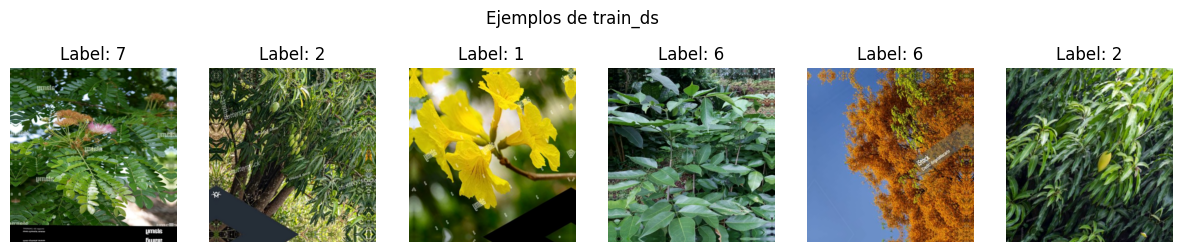

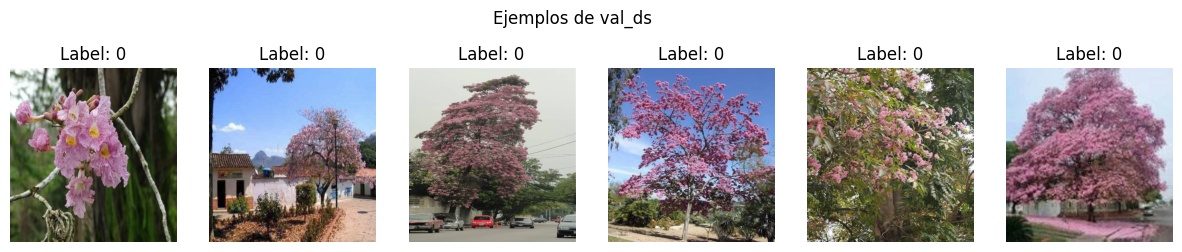

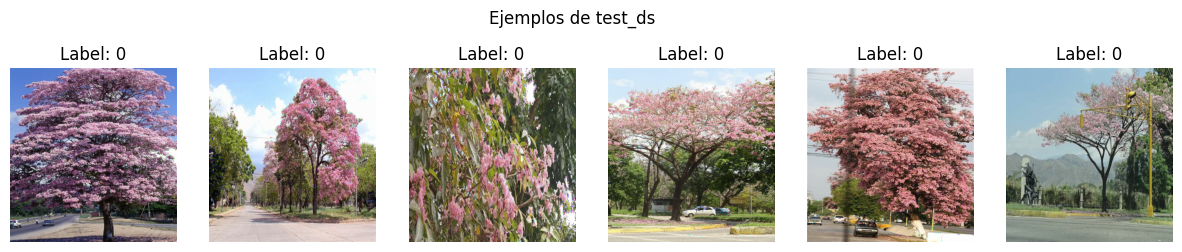

In [9]:
# Visualizar algunas imágenes de train, val y test después del preprocesamiento
def show_batch(dataset, title, n=6):
    plt.figure(figsize=(15, 3))
    for images, labels in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            img = images[i].numpy().astype("uint8")
            plt.imshow(img)
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_batch(train_ds, "Ejemplos de train_ds")
show_batch(val_ds, "Ejemplos de val_ds")
show_batch(test_ds, "Ejemplos de test_ds")

In [10]:
# Cargar MobileNetV3
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=image_size + (3,),
    include_top=False,
    weights='imagenet',
)

base_model.trainable = False  # No actualizar capas inferiores en las primeras épocas

In [11]:
# Asegúrate de definir explícitamente la capa de entrada con nombre y tipo
inputs = keras.Input(shape=image_size + (3,))
x = inputs

# Construir modelo de fine-tuning
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Capa de dropout para regularización
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 460, 440, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 15, 14, 960)       2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 8)                 7688      
                                                                 
Total params: 3004040 (11.46 MB)
Trainable params: 7688 (30.0

In [12]:
# Definir el Early Stopping
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1,
)

In [13]:
epochs_initial = 10
print(f"\nEntrenando las capas superiores por {epochs_initial} épocas...")
history_initial = model.fit(
    train_ds,
    epochs=epochs_initial,
    validation_data=val_ds,
    callbacks=[early_stopping_callback],
)


Entrenando las capas superiores por 10 épocas...
Epoch 1/10


44/44 [==============================] - 45s 744ms/step - loss: 1.8435 - accuracy: 0.3497 - val_loss: 1.2643 - val_accuracy: 0.5610
Epoch 2/10
44/44 [==============================] - 29s 651ms/step - loss: 1.1910 - accuracy: 0.6012 - val_loss: 0.9783 - val_accuracy: 0.6707
Epoch 3/10
44/44 [==============================] - 27s 608ms/step - loss: 0.9662 - accuracy: 0.6720 - val_loss: 0.8541 - val_accuracy: 0.7317
Epoch 4/10
44/44 [==============================] - 27s 605ms/step - loss: 0.8108 - accuracy: 0.7283 - val_loss: 0.7917 - val_accuracy: 0.7195
Epoch 5/10
44/44 [==============================] - 27s 611ms/step - loss: 0.7392 - accuracy: 0.7673 - val_loss: 0.7610 - val_accuracy: 0.7073
Epoch 6/10
44/44 [==============================] - 27s 613ms/step - loss: 0.6635 - accuracy: 0.8006 - val_loss: 0.7245 - val_accuracy: 0.6951
Epoch 7/10
44/44 [==============================] - 26s 596ms/step - loss: 0.5913 - accura

In [14]:
base_model.trainable = True

# Congelar capas de Batch Normalization (BN)
# Es una práctica común dejar las capas de Batch Normalization congeladas durante el fine-tuning,
# ya que sus estadísticas pueden volverse inestables con tamaños de batch pequeños.
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Recompilar el modelo con un learning rate más bajo
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=1e-5
    ),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 460, 440, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 15, 14, 960)       2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 8)                 7688      
                                                                 
Total params: 3004040 (11.46 MB)
Trainable params: 2955240 (1

In [15]:
epochs_fine_tune = 10  # Más épocas para el fine-tuning profundo
total_epochs = epochs_initial + epochs_fine_tune

print(
    f"\nContinuando el entrenamiento (fine-tuning profundo) por {epochs_fine_tune} épocas..."
)
history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history_initial.epoch[-1] + 1,
    validation_data=val_ds,
    callbacks=[early_stopping_callback],
)


Continuando el entrenamiento (fine-tuning profundo) por 10 épocas...
Epoch 11/20
44/44 [==============================] - 107s 2s/step - loss: 0.3728 - accuracy: 0.8887 - val_loss: 0.6219 - val_accuracy: 0.7683
Epoch 12/20
44/44 [==============================] - 95s 2s/step - loss: 0.2980 - accuracy: 0.9321 - val_loss: 0.6277 - val_accuracy: 0.7805
Epoch 13/20
44/44 [==============================] - 91s 2s/step - loss: 0.2689 - accuracy: 0.9220 - val_loss: 0.6222 - val_accuracy: 0.7927
Epoch 14/20
44/44 [==============================] - 92s 2s/step - loss: 0.2065 - accuracy: 0.9379 - val_loss: 0.6232 - val_accuracy: 0.7927
Epoch 15/20
44/44 [==============================] - 91s 2s/step - loss: 0.2093 - accuracy: 0.9408 - val_loss: 0.6117 - val_accuracy: 0.7927
Epoch 16/20
44/44 [==============================] - 92s 2s/step - loss: 0.1842 - accuracy: 0.9465 - val_loss: 0.6226 - val_accuracy: 0.7927
Epoch 17/20
44/44 [==============================] - 93s 2s/step - loss: 0.1542 - a

In [16]:
# --- 8. Evaluar el Modelo ---
loss, accuracy = model.evaluate(test_ds)
print(f"\nPrecisión en el conjunto de prueba: {accuracy * 100:.2f}%")


6/6 [==============================] - 4s 538ms/step - loss: 0.6037 - accuracy: 0.8316

Precisión en el conjunto de prueba: 83.16%


In [17]:
# --- 9. Guardar el Modelo ---
model.save("mobilenet_v3_plantas_model.h5")

c:\Users\Gabriel Mendez\Documents\UCAB\8vo Semestre\Inteligencia Artificial\llovizna-ai\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


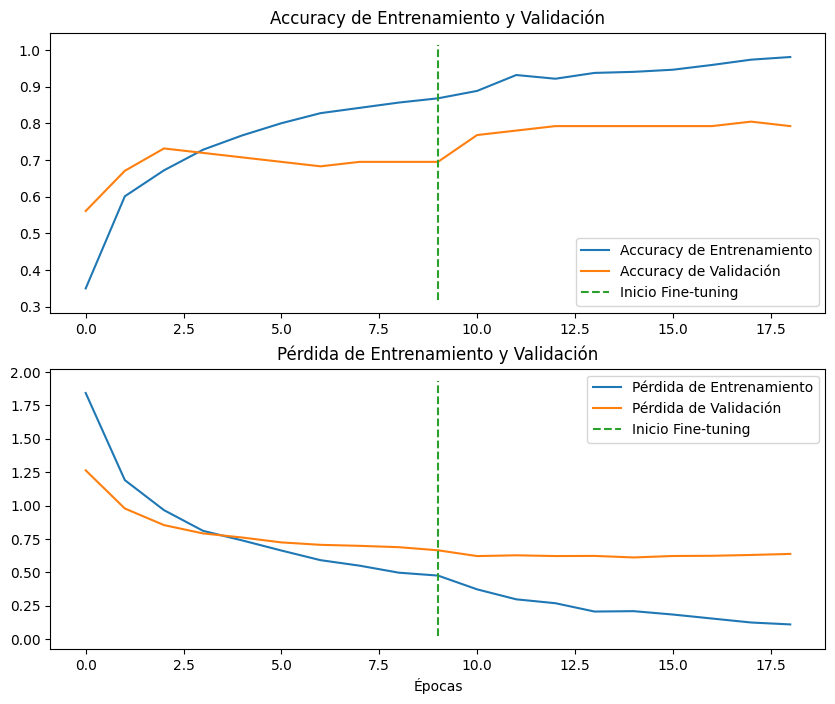

In [18]:
# --- 10. Visualizar el Historial de Entrenamiento ---
def plot_history(history_initial, history_fine_tune):
    acc = history_initial.history["accuracy"] + history_fine_tune.history["accuracy"]
    val_acc = (
        history_initial.history["val_accuracy"]
        + history_fine_tune.history["val_accuracy"]
    )
    loss = history_initial.history["loss"] + history_fine_tune.history["loss"]
    val_loss = (
        history_initial.history["val_loss"] + history_fine_tune.history["val_loss"]
    )

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label="Accuracy de Entrenamiento")
    plt.plot(val_acc, label="Accuracy de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="lower right")
    plt.title("Accuracy de Entrenamiento y Validación")

    plt.subplot(2, 1, 2)
    plt.plot(loss, label="Pérdida de Entrenamiento")
    plt.plot(val_loss, label="Pérdida de Validación")
    plt.plot(
        [epochs_initial - 1, epochs_initial - 1],
        plt.ylim(),
        label="Inicio Fine-tuning",
        linestyle="--",
    )
    plt.legend(loc="upper right")
    plt.title("Pérdida de Entrenamiento y Validación")
    plt.xlabel("Épocas")
    plt.show()


plot_history(history_initial, history_fine_tune)


1/1 [==============================] - 1s 501ms/step


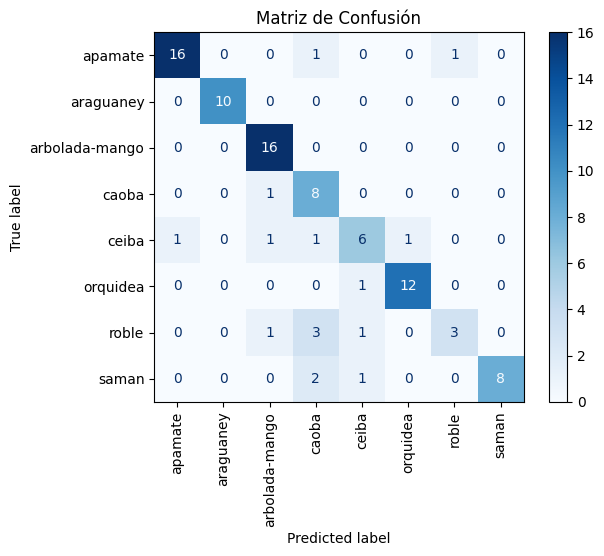

In [19]:
# Ver matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(model, test_ds):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(predictions.argmax(axis=1))

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Matriz de Confusión")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.xticks(rotation=90)
    plt.show()

plot_confusion_matrix(model, test_ds)